In [1]:
import numpy as np
import time
from numbers import Integral, Real
import scipy.sparse as sp
from scipy.special import expit, softmax  # logistic function

from sklearn.neural_network import BernoulliRBM
from sklearn.base import (
    BaseEstimator,
    ClassNamePrefixFeaturesOutMixin,
    TransformerMixin,
    _fit_context,
)
from sklearn.utils import check_random_state, gen_even_slices
from sklearn.utils._param_validation import Interval
from sklearn.utils.extmath import safe_sparse_dot
from sklearn.utils.validation import check_is_fitted

class RBM(BernoulliRBM):
    def __init__(self, n_components=2, learning_rate=0.1, batch_size=10, n_iter=10, verbose=0, random_state=None, add_bias=False, target_in_model=False, input_dist='bernoulli', latent_dist='bernoulli',target_dist='gaussian'):
        super().__init__(n_components=n_components, learning_rate=learning_rate,
                         batch_size=batch_size, n_iter=n_iter, verbose=verbose, random_state=random_state)
        self.add_bias = add_bias
        self.input_dist = input_dist # 'bernoulli' or 'gaussian'
        self.latent_dist = latent_dist # 'bernoulli' or 'multinomial'
        self.target_dist = target_dist # 'bernoulli' or 'gaussian'
        self.target_in_model = target_in_model

    def transform(self, X, y):
        """Compute the hidden layer activation probabilities, P(h=1|v=X).

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            The data to be transformed.

        Returns
        -------
        h : ndarray of shape (n_samples, n_components)
            Latent representations of the data.
        """
        check_is_fitted(self)
        # X = self._validate_data(
        #     X, accept_sparse="csr", reset=False, dtype=(np.float64, np.float32)
        # )
        return self._mean_hiddens(X, y)

    def _mean_hiddens(self, v, t):
        """Computes the probabilities P(h=1|v).

        Parameters
        ----------
        v : ndarray of shape (n_samples, n_features)
            Values of the visible layer.

        Returns
        -------
        h : ndarray of shape (n_samples, n_components)
            Corresponding mean field values for the hidden layer.
        """
        if (self.input_dist == 'bernoulli'):
            p = safe_sparse_dot(v, self.components_.T)
        elif (self.input_dist == 'gaussian'):
            p = safe_sparse_dot(v/self.sigma, self.components_.T)
        else:
            raise ValueError("Invalid input distribution: {}".format(self.input_dist))
        
        if (self.add_bias):
            p += self.intercept_hidden_

        if (self.target_in_model):
            if (self.target_dist == 'bernoulli'):
                p += safe_sparse_dot(t, self.target_components_)
            elif (self.target_dist == 'gaussian'):
                p += safe_sparse_dot(t/self.target_sigma, self.target_components_)
            else:
                raise ValueError("Invalid target distribution: {}".format(self.target_dist))
        
        if (self.latent_dist == 'bernoulli'):
            p = expit(p, out=p)
        elif (self.latent_dist == 'multinomial'):
            p = softmax(p)
        else:
            raise ValueError("Invalid latent distribution: {}".format(self.latent_dist))
        return p

    def _sample_hiddens(self, v, t, rng):
        """Sample from the distribution P(h|v).

        Parameters
        ----------
        v : ndarray of shape (n_samples, n_features)
            Values of the visible layer to sample from.

        rng : RandomState instance
            Random number generator to use.

        Returns
        -------
        h : ndarray of shape (n_samples, n_components)
            Values of the hidden layer.
        """
        p = self._mean_hiddens(v, t)
        if (self.latent_dist == 'bernoulli'):
            samples = rng.uniform(size=p.shape) < p
        elif (self.latent_dist == 'multinomial'):
            samples = [rng.multinomial(self.sample_size, pval) for pval in p]
            samples = np.array(samples)
        else:
            raise ValueError("Invalid latent distribution: {}".format(self.latent_dist))
        return samples

    def _mean_visibles(self, h):
        """Computes the probabilities P(v=1|h).

        Parameters
        ----------
        h : ndarray of shape (n_samples, n_components)
            Values of the hidden layer.

        Returns
        -------
        v : ndarray of shape (n_samples, n_features)
            Corresponding mean field values for the visible layer.
        """
        p = np.dot(h, self.components_)
        if (self.input_dist == 'gaussian'):
            p *= self.sigma
            if (self.add_bias):
                p += self.intercept_visible_
        elif (self.input_dist == 'bernoulli'):
            if (self.add_bias):
                p += self.intercept_visible_
            p = expit(p, out=p)
        else:
            raise ValueError("Invalid input distribution: {}".format(self.input_dist))

        return p
    
    def _sample_visibles(self, h, rng):
        """Sample from the distribution P(v|h).

        Parameters
        ----------
        h : ndarray of shape (n_samples, n_components)
            Values of the hidden layer to sample from.

        rng : RandomState instance
            Random number generator to use.

        Returns
        -------
        v : ndarray of shape (n_samples, n_features)
            Values of the visible layer.
        """
        p = self._mean_visibles(h)
        if (self.input_dist == 'gaussian'):
            samples = rng.normal(p, self.sigma, size=p.shape)
        elif (self.input_dist == 'bernoulli'):
            samples = rng.uniform(size=p.shape) < p
        else:
            raise ValueError("Invalid input distribution: {}".format(self.input_dist))
        return samples

    def _mean_targets(self, h):
        """Computes the probabilities P(t|h).

        Parameters
        ----------
        h : ndarray of shape (n_samples, n_components)
            Values of the hidden layer.

        Returns
        -------
        t : ndarray of shape (n_samples, n_targets)
            Corresponding mean field values for the target layer.
        """
        p = np.dot(h, self.target_components_.T)
        if (self.target_dist == 'gaussian'):
            p *= self.target_sigma
            if (self.add_bias):
                p += self.intercept_target_
        elif (self.target_dist == 'bernoulli'):
            if (self.add_bias):
                p += self.intercept_target_
            p = expit(p, out=p)
        else:
            raise ValueError("Invalid target distribution: {}".format(self.target_dist))
        return p
    
    def _sample_targets(self, h, rng):
        """Sample from the distribution P(t|h).

        Parameters
        ----------
        h : ndarray of shape (n_samples, n_components)
            Values of the hidden layer to sample from.

        rng : RandomState instance
            Random number generator to use.

        Returns
        -------
        t : ndarray of shape (n_samples, n_targets)
            Values of the target layer.
        """
        p = self._mean_targets(h)
        if (self.target_dist == 'bernoulli'):
            samples = rng.uniform(size=p.shape) < p
        elif (self.target_dist == 'gaussian'):
            samples = rng.normal(p, self.target_sigma, size=p.shape)
        else:
            raise ValueError("Invalid target distribution: {}".format(self.target_dist))
        return samples
    
    def _free_energy(self, v, t):
        """Computes the free energy F(v) = - log sum_h exp(-E(v,h)).

        Parameters
        ----------
        v : ndarray of shape (n_samples, n_features)
            Values of the visible layer.

        Returns
        -------
        free_energy : ndarray of shape (n_samples,)
            The value of the free energy.
        """
        if (self.add_bias and self.input_dist == 'gaussian'):
            input_energy = np.sum(((v - self.intercept_visible_) / self.sigma) ** 2, axis=1) - np.logaddexp(0, safe_sparse_dot(v/(self.sigma ** 2), self.components__.T) + self.intercept_hidden_).sum(axis=1)
        elif (self.add_bias and self.input_dist == 'bernoulli'):
            input_energy = -safe_sparse_dot(v, self.intercept_visible_) - np.logaddexp(0, safe_sparse_dot(v, self.components_.T) + self.intercept_hidden_).sum(axis=1)
        elif (self.input_dist == 'gaussian'):
            input_energy = np.sum((v / self.sigma) ** 2, axis=1) - np.logaddexp(0, safe_sparse_dot(v/(self.sigma ** 2), self.components__.T)).sum(axis=1)
        elif (self.input_dist == 'bernoulli'):
            input_energy = - np.logaddexp(0, safe_sparse_dot(v, self.components_.T)).sum(axis=1)
        else:
            raise ValueError("Invalid input distribution: {}".format(self.input_dist))
        
        if (self.target_in_model):
            if (self.add_bias and self.target_dist == 'gaussian'):
                target_energy = np.sum(((t - self.intercept_target_) / self.target_sigma) ** 2, axis=1) - np.logaddexp(0, safe_sparse_dot(t/(self.target_sigma ** 2), self.target_components__) + self.intercept_hidden_).sum(axis=1)
            elif (self.add_bias and self.target_dist == 'bernoulli'):
                target_energy = -safe_sparse_dot(t, self.intercept_target_) - np.logaddexp(0, safe_sparse_dot(t, self.target_components_) + self.intercept_hidden_).sum(axis=1)
            elif (self.target_dist == 'gaussian'):
                target_energy = np.sum((t / self.target_sigma) ** 2, axis=1) - np.logaddexp(0, safe_sparse_dot(t/(self.target_sigma ** 2), self.target_components__)).sum(axis=1)
            elif (self.target_dist == 'bernoulli'):
                target_energy = - np.logaddexp(0, safe_sparse_dot(t, self.target_components_)).sum(axis=1)
            else:
                raise ValueError("Invalid target distribution: {}".format(self.target_dist))
        else:
            target_energy = 0.
        return input_energy + target_energy

    def gibbs(self, v, t):
        """Perform one Gibbs sampling step.

        Parameters
        ----------
        v : ndarray of shape (n_samples, n_features)
            Values of the visible layer to start from.

        Returns
        -------
        v_new : ndarray of shape (n_samples, n_features)
            Values of the visible layer after one Gibbs step.
        """
        check_is_fitted(self)
        if not hasattr(self, "random_state_"):
            self.random_state_ = check_random_state(self.random_state)
        h_ = self._sample_hiddens(v, t, self.random_state_)
        v_ = self._sample_visibles(h_, self.random_state_)
        t_ = self._sample_targets(h_, self.random_state_)

        return v_, t_

    @_fit_context(prefer_skip_nested_validation=True)
    def partial_fit(self, X, y=None):
        """Fit the model to the partial segment of the data X.

        Parameters
        ----------
        X : ndarray of shape (n_samples, n_features)
            Training data.

        y : array-like of shape (n_samples,) or (n_samples, n_outputs), default=None
            Target values (None for unsupervised transformations).

        Returns
        -------
        self : BernoulliRBM
            The fitted model.
        """
        first_pass = not hasattr(self, "components_")
        X = self._validate_data(
            X, accept_sparse="csr", dtype=np.float64, reset=first_pass
        )
        if not hasattr(self, "random_state_"):
            self.random_state_ = check_random_state(self.random_state)
        if not hasattr(self, "components_"):
            self.components_ = np.asarray(
                self.random_state_.normal(0, 0.01, (self.n_components, X.shape[1])),
                order="F",
            )
            self._n_features_out = self.components_.shape[0]
        if not hasattr(self, "intercept_hidden_"):
            self.intercept_hidden_ = np.zeros(
                self.n_components,
            )
        if not hasattr(self, "intercept_visible_"):
            self.intercept_visible_ = np.zeros(
                X.shape[1],
            )
        if not hasattr(self, "h_samples_"):
            self.h_samples_ = np.zeros((self.batch_size, self.n_components))

        self._fit(X, y, self.random_state_)

    def _fit(self, v_pos, t_pos, rng):
        """Inner fit for one mini-batch.

        Adjust the parameters to maximize the likelihood of v using
        Stochastic Maximum Likelihood (SML).

        Parameters
        ----------
        v_pos : ndarray of shape (n_samples, n_features)
            The data to use for training.

        rng : RandomState instance
            Random number generator to use for sampling.
        """
        h_pos = self._mean_hiddens(v_pos, t_pos)
        v_neg = self._sample_visibles(self.h_samples_, rng)
        t_neg = self._sample_targets(self.h_samples_, rng)
        h_neg = self._mean_hiddens(v_neg, t_neg)
        

        lr = float(self.learning_rate) / v_pos.shape[0]
        update = safe_sparse_dot(v_pos.T, h_pos, dense_output=True).T
        update -= np.dot(h_neg.T, v_neg)
        self.components_ += lr * update
        self.intercept_hidden_ += lr * (h_pos.sum(axis=0) - h_neg.sum(axis=0))
        self.intercept_visible_ += lr * (
            np.asarray(v_pos.sum(axis=0)).squeeze() - v_neg.sum(axis=0)
        )

        if (self.target_in_model):
            update_target = safe_sparse_dot(h_pos.T, t_pos/self.target_sigma, dense_output=True).T
            update_target -= np.dot(h_neg.T, t_neg/self.target_sigma).T
            self.target_components_ += lr/100. * update_target
            self.intercept_target_ += lr/100. * (np.sum(t_pos/(self.target_sigma**2), axis=0) - np.sum(t_neg/(self.target_sigma**2), axis=0))

        if (self.latent_dist == 'multinomial'):
            self.h_samples_ = [rng.multinomial(self.sample_size, pval) for pval in h_neg]
            self.h_samples_ = np.array(self.h_samples_)
        elif (self.latent_dist == 'bernoulli'):
            h_neg[rng.uniform(size=h_neg.shape) < h_neg] = 1.0  # sample binomial
            self.h_samples_ = np.floor(h_neg, h_neg)
        else:
            raise ValueError("Invalid latent distribution: {}".format(self.latent_dist))

    def score_samples(self, X, y):
        """Compute the pseudo-likelihood of X.

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            Values of the visible layer. Must be all-boolean (not checked).

        Returns
        -------
        pseudo_likelihood : ndarray of shape (n_samples,)
            Value of the pseudo-likelihood (proxy for likelihood).

        Notes
        -----
        This method is not deterministic: it computes a quantity called the
        free energy on X, then on a randomly corrupted version of X, and
        returns the log of the logistic function of the difference.
        """
        check_is_fitted(self)

        v = self._validate_data(X, accept_sparse="csr", reset=False)
        t = self._validate_data(y, accept_sparse="csr", reset=False)
        rng = check_random_state(self.random_state)

        # Randomly corrupt one feature in each sample in v.
        ind = (np.arange(v.shape[0]), rng.randint(0, v.shape[1], v.shape[0]))
        if sp.issparse(v):
            data = -2 * v[ind] + 1
            if isinstance(data, np.matrix):  # v is a sparse matrix
                v_ = v + sp.csr_matrix((data.A.ravel(), ind), shape=v.shape)
            else:  # v is a sparse array
                v_ = v + sp.csr_array((data.ravel(), ind), shape=v.shape)
        else:
            v_ = v.copy()
            v_[ind] = 1 - v_[ind]

        fe = self._free_energy(v, t)
        fe_ = self._free_energy(v_, t)
        # log(expit(x)) = log(1 / (1 + exp(-x)) = -np.logaddexp(0, -x)
        return -v.shape[1] * np.logaddexp(0, -(fe_ - fe))

    @_fit_context(prefer_skip_nested_validation=True)
    def fit(self, X, y, sample_size=100):
        """Fit the model to the data X.

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            Training data.

        y : array-like of shape (n_samples,) or (n_samples, n_outputs).

        Returns
        -------
        self : BernoulliRBM
            The fitted model.
        """
        X = self._validate_data(X, accept_sparse="csr", dtype=(np.float64, np.float32))
        y = self._validate_data(y, accept_sparse="csr", dtype=(np.float64, np.float32))
        n_samples = X.shape[0]
        
        rng = check_random_state(self.random_state)

        self.sample_size = sample_size
        self.components_ = np.asarray(
            rng.normal(0, 0.01, (self.n_components, X.shape[1])),
            order="F",
            dtype=X.dtype,
        )
        self.sigma = 0.1
        self.target_sigma = 0.1
        self.target_components_ = np.asarray(
            rng.normal(0, 0.01, (y.shape[1], self.n_components)),
            order="F",
            dtype=y.dtype,
        )
            
        self.intercept_target_ = np.zeros(y.shape[1], dtype=y.dtype)
        self._n_features_out = self.components_.shape[0]
        self.intercept_hidden_ = np.zeros(self.n_components, dtype=X.dtype)
        self.intercept_visible_ = np.zeros(X.shape[1], dtype=X.dtype)
        self.h_samples_ = np.zeros((self.batch_size, self.n_components), dtype=X.dtype)

        n_batches = int(np.ceil(float(n_samples) / self.batch_size))
        batch_slices = list(
            gen_even_slices(n_batches * self.batch_size, n_batches, n_samples=n_samples)
        )
        verbose = self.verbose
        begin = time.time()
        for iteration in range(1, self.n_iter + 1):
            for batch_slice in batch_slices:
                self._fit(X[batch_slice], y[batch_slice], rng)

            if verbose:
                end = time.time()
                print(
                    "[%s] Iteration %d, pseudo-likelihood = %.2f, time = %.2fs"
                    % (
                        type(self).__name__,
                        iteration,
                        self.score_samples(X).mean(),
                        end - begin,
                    )
                )
                begin = end

        return self

    def _more_tags(self):
        return {
            "_xfail_checks": {
                "check_methods_subset_invariance": (
                    "fails for the decision_function method"
                ),
                "check_methods_sample_order_invariance": (
                    "fails for the score_samples method"
                ),
            },
            "preserves_dtype": [np.float64, np.float32],
        }


In [2]:
def project_points_to_simplex(points):
    """
    Projects each point in a multidimensional cube [0, 1]^n onto the n-dimensional simplex.

    Parameters:
        points (np.ndarray): A 2D numpy array where each row is a point in the hypercube [0, 1]^n.

    Returns:
        np.ndarray: A 2D numpy array with each row projected onto the n-dimensional simplex.
    """
    # Number of points and dimension
    num_points, dim = points.shape
    
    # Array to store the projected points
    projected_points = np.zeros_like(points)
    
    for i in range(num_points):
        point = points[i]
        
        # Step 1: Sort the point in descending order
        u = np.sort(point)[::-1]
        
        # Step 2: Find the largest k such that the projection condition holds
        cumulative_sum = np.cumsum(u)
        rho = np.where(u > (cumulative_sum - 1) / (np.arange(dim) + 1))[0][-1]
        
        # Step 3: Compute theta
        theta = (cumulative_sum[rho] - 1) / (rho + 1)
        
        # Step 4: Project point onto the simplex
        projected_points[i] = np.maximum(point - theta, 0)
    
    return projected_points

In [3]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import binarize

# Load the MNIST dataset from OpenML
mnist = fetch_openml('mnist_784', version=1, as_frame=False)

# Extract features and labels
X, y = mnist['data'], mnist['target']
y = y.astype(np.int32)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Preprocess the data
X_train = X_train.reshape(-1, 784) / 255.0  # Normalize to [0,1] and flatten
X_test = X_test.reshape(-1, 784) / 255.0
y_train_input = y_train.reshape(X_train.shape[0], -1) / 10.0
y_test_input = y_test.reshape(y_test.shape[0], -1) / 10.0

# Binarize the images, as RBMs work best with binary input
X_train_bin = binarize(X_train, threshold=0.5)
X_test_bin = binarize(X_test, threshold=0.5)

In [4]:
from umap import UMAP
import matplotlib.pyplot as plt    
import warnings

/home/leo/miniforge3/envs/tensorflow/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-15 07:53:14.926593: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-15 07:53:14.939936: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-15 07:53:14.945717: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-15 07:53:14.995371: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFl

/home/leo/miniforge3/envs/tensorflow/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


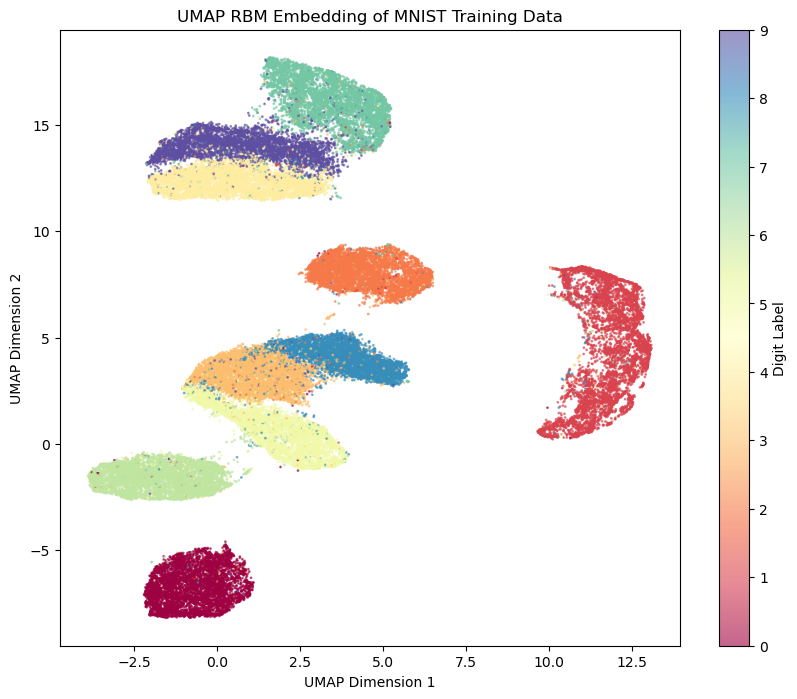

/home/leo/miniforge3/envs/tensorflow/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


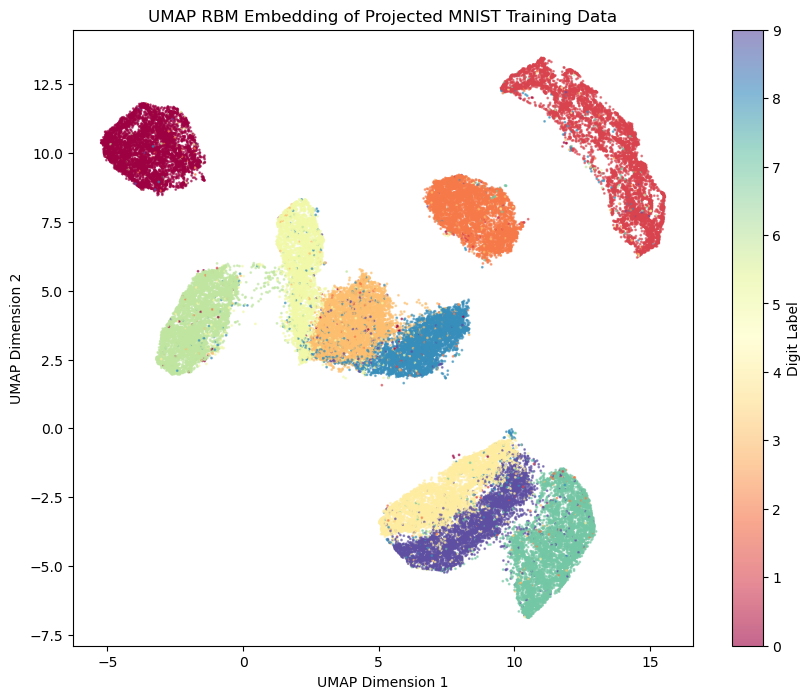

In [5]:
rbm = RBM(n_components=128, learning_rate=0.06, n_iter=10, verbose=0, random_state=0, add_bias=False, target_in_model=True, input_dist='bernoulli', latent_dist='bernoulli', target_dist='gaussian')
# # Treat warnings as errors
# warnings.simplefilter("error")

# Fit RBM to the MNIST training data
rbm.fit(X_train_bin, y_train_input)

# Extract embeddings (transform) for train and test sets
X_train_embedded = rbm.transform(X_train_bin, y_train_input)
X_test_embedded = rbm.transform(X_test_bin, y_test_input)
X_train_simplex = project_points_to_simplex(X_train_embedded)
X_test_simplex = project_points_to_simplex(X_test_embedded)

# Initialize UMAP with desired parameters
umap = UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
warnings.simplefilter("default")
# Fit and transform the data
X_train_umap = umap.fit_transform(X_train_embedded)

# Plot the results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_train_umap[:, 0], X_train_umap[:, 1], c=y_train, cmap="Spectral", s=1, alpha=0.6)
plt.colorbar(scatter, label="Digit Label")
plt.title("UMAP RBM Embedding of MNIST Training Data")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()

# Initialize UMAP with desired parameters
umap = UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
warnings.simplefilter("default")
# Fit and transform the data
X_train_umap = umap.fit_transform(X_train_simplex)

# Plot the results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_train_umap[:, 0], X_train_umap[:, 1], c=y_train, cmap="Spectral", s=1, alpha=0.6)
plt.colorbar(scatter, label="Digit Label")
plt.title("UMAP RBM Embedding of Projected MNIST Training Data")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()

/home/leo/miniforge3/envs/tensorflow/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


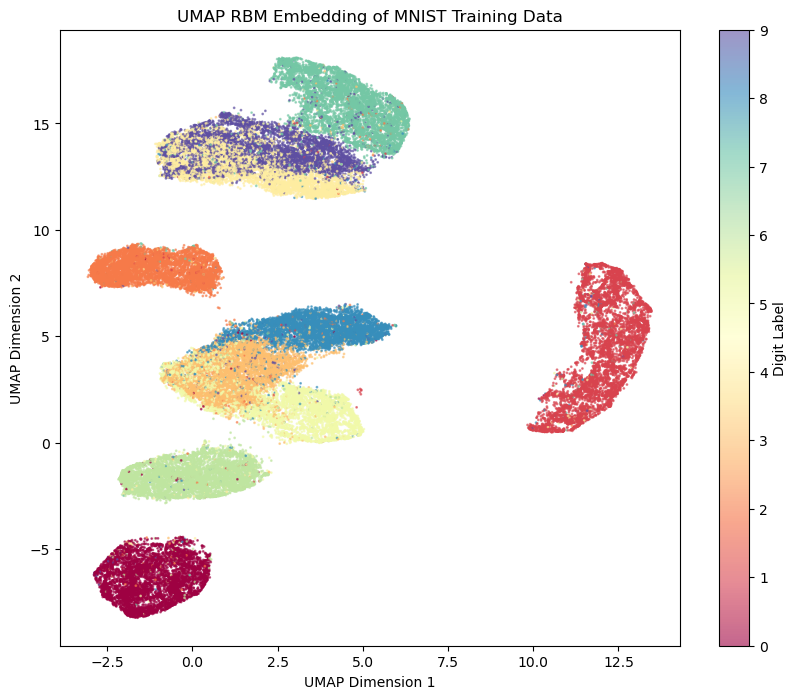

/home/leo/miniforge3/envs/tensorflow/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


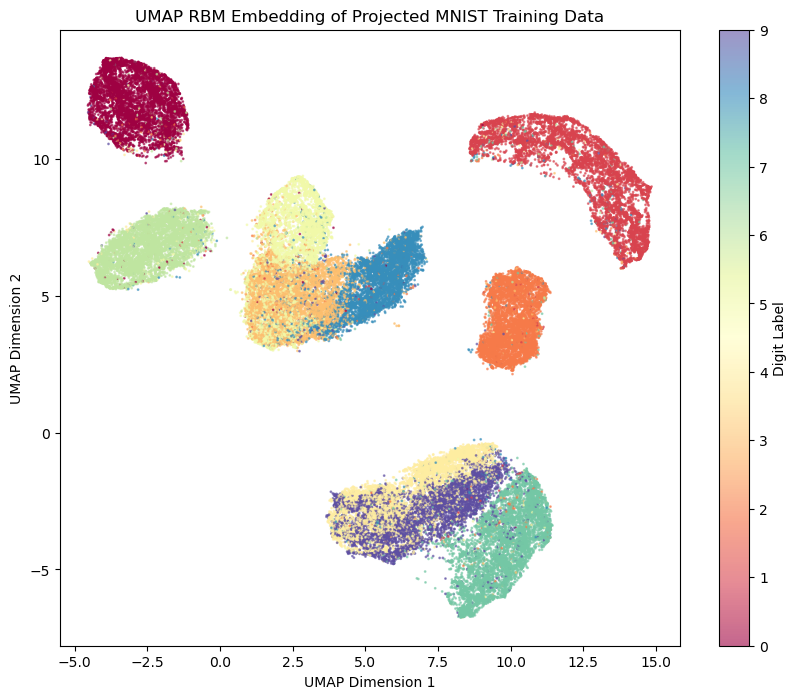

In [6]:
rbm = RBM(n_components=128, learning_rate=0.06, n_iter=10, verbose=0, random_state=0, add_bias=False, target_in_model=False, input_dist='bernoulli', latent_dist='bernoulli', target_dist='gaussian')
# # Treat warnings as errors
# warnings.simplefilter("error")

# Fit RBM to the MNIST training data
rbm.fit(X_train_bin, y_train_input)

# Extract embeddings (transform) for train and test sets
X_train_embedded = rbm.transform(X_train_bin, y_train_input)
X_test_embedded = rbm.transform(X_test_bin, y_test_input)
X_train_simplex = project_points_to_simplex(X_train_embedded)
X_test_simplex = project_points_to_simplex(X_test_embedded)

# Initialize UMAP with desired parameters
umap = UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
warnings.simplefilter("default")
# Fit and transform the data
X_train_umap = umap.fit_transform(X_train_embedded)

# Plot the results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_train_umap[:, 0], X_train_umap[:, 1], c=y_train, cmap="Spectral", s=1, alpha=0.6)
plt.colorbar(scatter, label="Digit Label")
plt.title("UMAP RBM Embedding of MNIST Training Data")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()

# Initialize UMAP with desired parameters
umap = UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
warnings.simplefilter("default")
# Fit and transform the data
X_train_umap = umap.fit_transform(X_train_simplex)

# Plot the results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_train_umap[:, 0], X_train_umap[:, 1], c=y_train, cmap="Spectral", s=1, alpha=0.6)
plt.colorbar(scatter, label="Digit Label")
plt.title("UMAP RBM Embedding of Projected MNIST Training Data")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()

/home/leo/miniforge3/envs/tensorflow/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


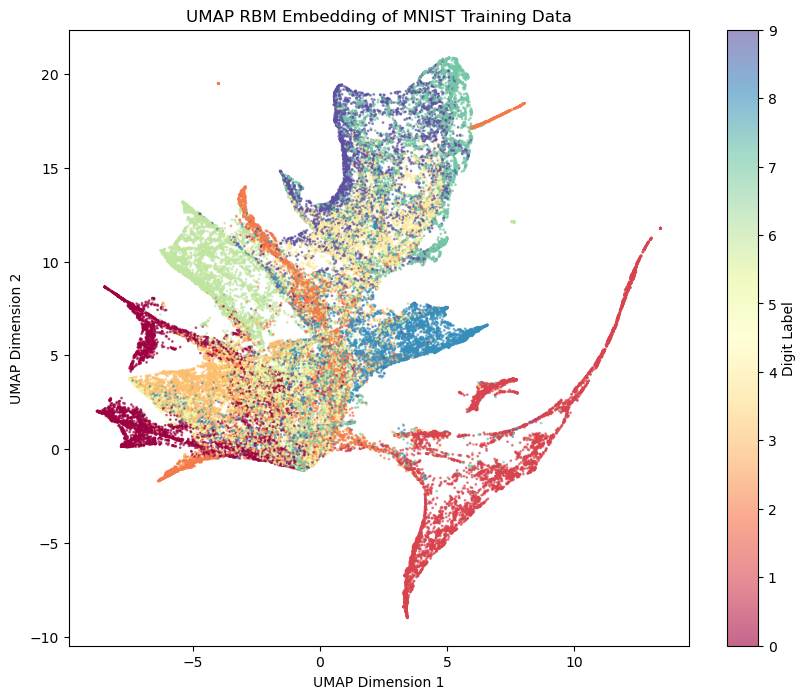

/home/leo/miniforge3/envs/tensorflow/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


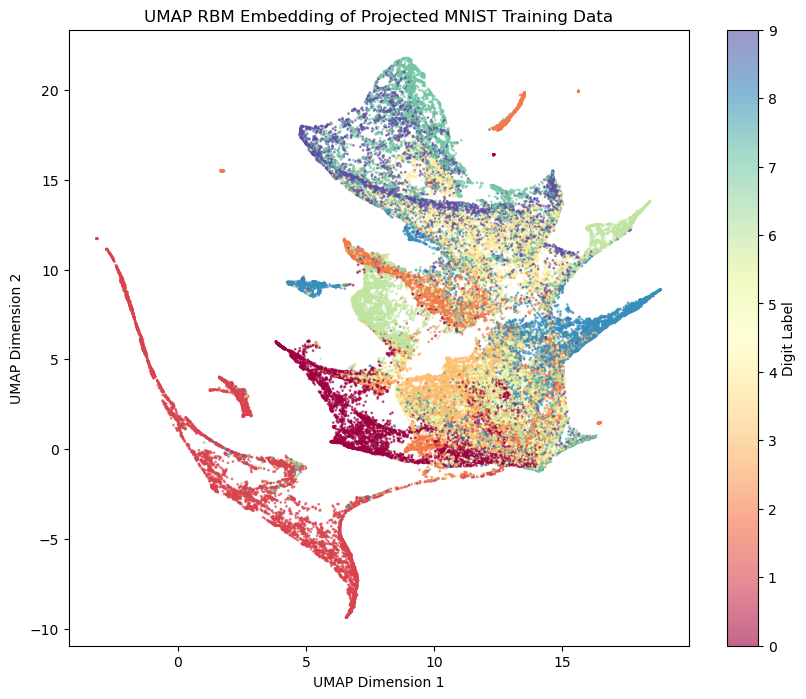

In [7]:
rbm = RBM(n_components=128, learning_rate=0.06, n_iter=10, verbose=0, random_state=0, add_bias=False, target_in_model=True, input_dist='bernoulli', latent_dist='multinomial', target_dist='gaussian')
# # Treat warnings as errors
# warnings.simplefilter("error")

# Fit RBM to the MNIST training data
rbm.fit(X_train_bin, y_train_input)

# Extract embeddings (transform) for train and test sets
X_train_embedded = rbm.transform(X_train_bin, y_train_input)
X_test_embedded = rbm.transform(X_test_bin, y_test_input)
X_train_simplex = project_points_to_simplex(X_train_embedded)
X_test_simplex = project_points_to_simplex(X_test_embedded)

# Initialize UMAP with desired parameters
umap = UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
warnings.simplefilter("default")
# Fit and transform the data
X_train_umap = umap.fit_transform(X_train_embedded)

# Plot the results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_train_umap[:, 0], X_train_umap[:, 1], c=y_train, cmap="Spectral", s=1, alpha=0.6)
plt.colorbar(scatter, label="Digit Label")
plt.title("UMAP RBM Embedding of MNIST Training Data")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()

# Initialize UMAP with desired parameters
umap = UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
warnings.simplefilter("default")
# Fit and transform the data
X_train_umap = umap.fit_transform(X_train_simplex)

# Plot the results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_train_umap[:, 0], X_train_umap[:, 1], c=y_train, cmap="Spectral", s=1, alpha=0.6)
plt.colorbar(scatter, label="Digit Label")
plt.title("UMAP RBM Embedding of Projected MNIST Training Data")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()

/home/leo/miniforge3/envs/tensorflow/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


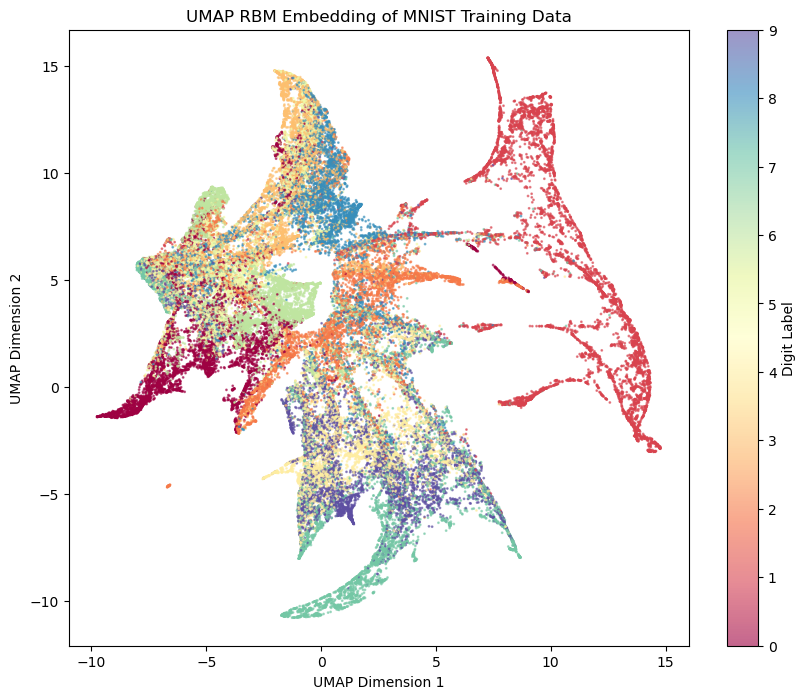

/home/leo/miniforge3/envs/tensorflow/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


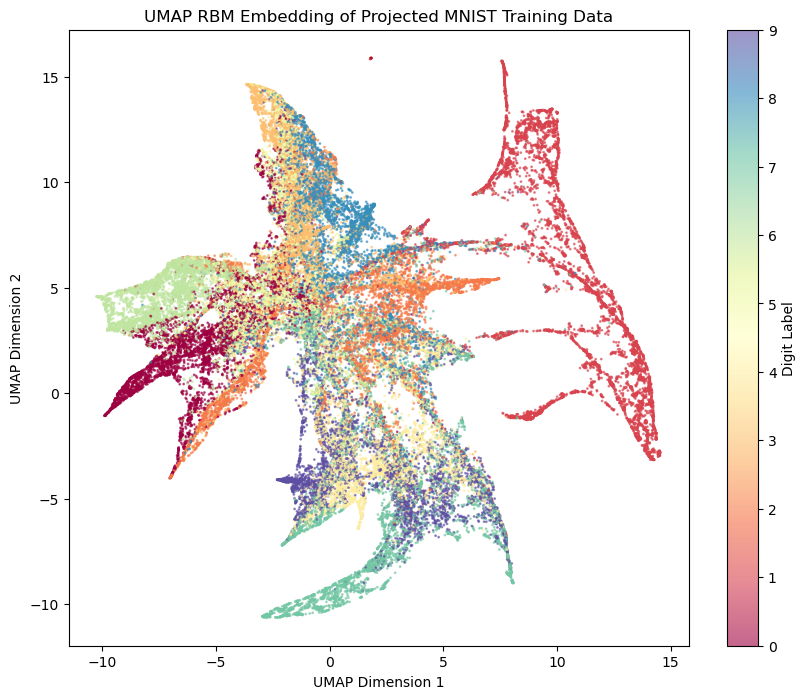

In [8]:
rbm = RBM(n_components=128, learning_rate=0.06, n_iter=10, verbose=0, random_state=0, add_bias=False, target_in_model=False, input_dist='bernoulli', latent_dist='multinomial', target_dist='gaussian')
# # Treat warnings as errors
# warnings.simplefilter("error")

# Fit RBM to the MNIST training data
rbm.fit(X_train_bin, y_train_input)

# Extract embeddings (transform) for train and test sets
X_train_embedded = rbm.transform(X_train_bin, y_train_input)
X_test_embedded = rbm.transform(X_test_bin, y_test_input)
X_train_simplex = project_points_to_simplex(X_train_embedded)
X_test_simplex = project_points_to_simplex(X_test_embedded)

# Initialize UMAP with desired parameters
umap = UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
warnings.simplefilter("default")
# Fit and transform the data
X_train_umap = umap.fit_transform(X_train_embedded)

# Plot the results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_train_umap[:, 0], X_train_umap[:, 1], c=y_train, cmap="Spectral", s=1, alpha=0.6)
plt.colorbar(scatter, label="Digit Label")
plt.title("UMAP RBM Embedding of MNIST Training Data")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()

# Initialize UMAP with desired parameters
umap = UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
warnings.simplefilter("default")
# Fit and transform the data
X_train_umap = umap.fit_transform(X_train_simplex)

# Plot the results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_train_umap[:, 0], X_train_umap[:, 1], c=y_train, cmap="Spectral", s=1, alpha=0.6)
plt.colorbar(scatter, label="Digit Label")
plt.title("UMAP RBM Embedding of Projected MNIST Training Data")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()